# Competição de modelagem (Ponderada Semana 04)

## Detalhes da base de dados:

Shape da base (completa):
- Linhas: 923

- Colunas: 32

Observações gerais:

- Colunas age_* podem ter NaN (evento não ocorreu).
  
- category_code é uma variável categórica bruta.
  
- As demais dummies são binárias 0/1.

- Faltantes (NaN): principalmente em age_* e outliers de funding_total_usd → tratar no pipeline (ex.: imputação por mediana ou uso de modelos robustos).

- Escalas: variáveis como funding_total_usd, relationships, funding_rounds e avg_participants têm ordens de grandeza diferentes → recomenda-se normalização/padronização (StandardScaler) em modelos lineares.

- Vazamento evitado: colunas como status, closed_at, is_top500, datas cruas e identificadores foram removidas.

- Balanceamento: verifique a proporção de labels ao treinar; se necessário, use class_weight, threshold tuning ou métricas robustas (AUC/F1).

Variáveis: 

- label | int64 | Target | Indicador de sucesso | {0, 1} | 1 = sucesso (ativa/adquirida); 0 = fechada

- age_first_funding_year | float64 | Anos até o primeiro funding | ≥ 0 ou NaN.

- age_last_funding_year | float64 | Anos até o último funding | ≥ 0 ou NaN.

- age_first_milestone_year | float64 | Anos até o primeiro milestone | ≥ 0 ou NaN (muitos NaN).

- age_last_milestone_year | float64 | Anos até o último milestone | ≥ 0 ou NaN (muitos NaN).

- relationships | int64 | Contagem de relações (fundadores, executivos, investidores) | ≥ 0.

- funding_rounds | int64 | Número de rodadas de captação | ≥ 0.

- funding_total_usd | float64 | Total captado (USD) | Outliers suavizados (IQR → valores extremos viraram NaN).

- milestones | int64 | Contagem de marcos relevantes | ≥ 0.

- avg_participants | float64 | Média de investidores por rodada | ≥ 0.

- is_CA, is_NY, is_MA, is_TX, is_otherstate | int64 | Estado (Califórnia, Nova Iorque, Massachusetts, Texas, Outros) | {0,1}.

- is_software, is_web, is_mobile, is_enterprise, is_advertising, is_gamesvideo, is_ecommerce, is_biotech, is_consulting, is_othercategory | int64 | Indicadores de setor | {0,1}

- has_VC | int64 | Recebeu venture capital? | {0,1}.

- has_angel | int64 | Recebeu investimento angel? | {0,1}.

- has_roundA, has_roundB, has_roundC, has_roundD | int64 | Teve a respectiva rodada? | {0,1}.


###

### Importação das Bibliotecas 

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier

### Leitura e Análise geral inicial dos dataframes

Shape do dataset: (277, 32)
Shape do dataset: (646, 33)
Distribuição da variável alvo:
labels
1    418
0    228
Name: count, dtype: int64

Proporção:
labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64


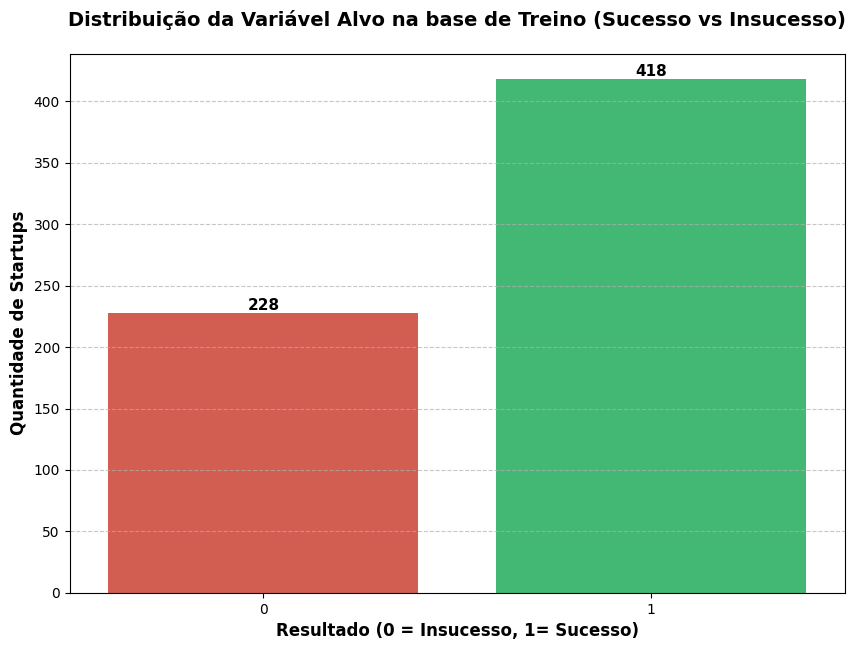

In [378]:
df_test = pd.read_csv("database/test.csv")
df_train = pd.read_csv("database/train.csv")


# Realiza análise do shape dos dataframes (linhas x colunas)
print("Shape do dataset:", df_test.shape)
print("Shape do dataset:", df_train.shape)

# Realiza a análise da variável alvo
print("Distribuição da variável alvo:")
print(df_train['labels'].value_counts())
print("\nProporção:")
print(df_train['labels'].value_counts(normalize=True))

# Cria um gráfico de colunas para verificar a proporção dos resultados no dataframe de treino
plt.figure(figsize=(10, 7))
ax = sns.countplot(data=df_train, x='labels', hue='labels', palette=['#e74c3c', '#2ecc71'], legend=False)
plt.title('Distribuição da Variável Alvo na base de Treino (Sucesso vs Insucesso)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Resultado (0 = Insucesso, 1= Sucesso)', fontsize=12, fontweight='bold')
plt.ylabel('Quantidade de Startups', fontsize=12, fontweight='bold')

# Adiciona grid ao gráfico para melhor visualização
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adiciona valores logo acima das colunas para melhor entendimento durante análise
for i, p in enumerate(ax.patches):
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()

### Hipóteses

#### 1 - Startups que chegaram pelo menos ao roundA tem mais chance de sucesso

In [ ]:
# Criar feature para identificar se chegou ao Round A ou além
df_train['reached_roundA_or_beyond'] = (
    (df_train['has_roundA'] == 1) | 
    (df_train['has_roundB'] == 1) | 
    (df_train['has_roundC'] == 1) | 
    (df_train['has_roundD'] == 1)
).astype(int)

# Calcula proporções por round
round_analysis = df_train.groupby('reached_roundA_or_beyond')['labels'].agg(['count', 'sum', 'mean']).reset_index()
round_analysis.columns = ['Chegou_RoundA+', 'Total_Startups', 'Sucessos', 'Taxa_Sucesso']
round_analysis['Chegou_RoundA+'] = round_analysis['Chegou_RoundA+'].map({0: 'Não chegou ao Round A', 1: 'Chegou ao Round A+'})

print("\nResultados da Hipótese 1:")
print(round_analysis)

# Gráfico da Hipótese 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Contagem por categoria
round_counts = df_train.groupby(['reached_roundA_or_beyond', 'labels']).size().unstack(fill_value=0)
round_counts.index = ['Não chegou ao Round A', 'Chegou ao Round A+']
round_counts.columns = ['Insucesso', 'Sucesso']

round_counts.plot(kind='bar', ax=ax1, color=['#e74c3c', '#2ecc71'], alpha=0.8)
ax1.set_title('Hipótese 1: Distribuição de Sucesso por Round A+', fontsize=12, fontweight='bold')
ax1.set_xlabel('Chegou ao Round A ou além?', fontweight='bold')
ax1.set_ylabel('Quantidade de Startups', fontweight='bold')
ax1.legend(title='Resultado')
ax1.tick_params(axis='x', rotation=45)

# Adicionar valores nas barras
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d')

# Gráfico 2: Taxa de sucesso
taxa_sucesso = df_train.groupby('reached_roundA_or_beyond')['labels'].mean()
categories = ['Não chegou ao Round A', 'Chegou ao Round A+']
colors = ['#e74c3c', '#2ecc71']

bars = ax2.bar(categories, taxa_sucesso.values, color=colors, alpha=0.8)
ax2.set_title('Hipótese 1: Taxa de Sucesso por Round A+', fontsize=12, fontweight='bold')
ax2.set_xlabel('Chegou ao Round A ou além?', fontweight='bold')
ax2.set_ylabel('Taxa de Sucesso', fontweight='bold')
ax2.set_ylim(0, 1)

# Adicionar valores nas barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01, 
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


#### 2 - Startups que demoraram a atingir seu primeiro milestone tendem ao sucesso

In [ ]:
startups_with_milestones = df_train[df_train['milestones'] > 0].copy()

print(f"\nStartups com pelo menos 1 milestone: {len(startups_with_milestones)}")

if len(startups_with_milestones) > 0:
    # Criar categorias de tempo para primeiro milestone
    startups_with_milestones['milestone_speed_category'] = pd.cut(
        startups_with_milestones['age_first_milestone_year'], 
        bins=[0, 2, 5, float('inf')], 
        labels=['Rápido (0-2 anos)', 'Médio (2-5 anos)', 'Lento (5+ anos)'],
        include_lowest=True
    )

    # Análise da hipótese 2
    milestone_analysis = startups_with_milestones.groupby('milestone_speed_category')['labels'].agg(['count', 'sum', 'mean']).reset_index()
    milestone_analysis.columns = ['Velocidade_Milestone', 'Total_Startups', 'Sucessos', 'Taxa_Sucesso']
    
    print("\nResultados da Hipótese 2:")
    print(milestone_analysis)

    # Gráfico da Hipótese 2
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Gráfico 1: Distribuição por velocidade de milestone
    milestone_counts = startups_with_milestones.groupby(['milestone_speed_category', 'labels']).size().unstack(fill_value=0)
    milestone_counts.columns = ['Insucesso', 'Sucesso']

    milestone_counts.plot(kind='bar', ax=ax1, color=['#e74c3c', '#2ecc71'], alpha=0.8)
    ax1.set_title('Hipótese 2: Distribuição por Velocidade do 1º Milestone', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Velocidade para 1º Milestone', fontweight='bold')
    ax1.set_ylabel('Quantidade de Startups', fontweight='bold')
    ax1.legend(title='Resultado')
    ax1.tick_params(axis='x', rotation=45)

    # Adicionar valores nas barras
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%d')

    # Gráfico 2: Taxa de sucesso por velocidade
    taxa_sucesso_milestone = startups_with_milestones.groupby('milestone_speed_category')['labels'].mean()
    colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Verde, laranja, vermelho

    bars = ax2.bar(range(len(taxa_sucesso_milestone)), taxa_sucesso_milestone.values, 
                   color=colors[:len(taxa_sucesso_milestone)], alpha=0.8)
    ax2.set_title('Hipótese 2: Taxa de Sucesso por Velocidade do 1º Milestone', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Velocidade para 1º Milestone', fontweight='bold')
    ax2.set_ylabel('Taxa de Sucesso', fontweight='bold')
    ax2.set_xticks(range(len(taxa_sucesso_milestone)))
    ax2.set_xticklabels(taxa_sucesso_milestone.index, rotation=45)
    ax2.set_ylim(0, 1)

    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01, 
                 f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

else:
    print("Não há dados suficientes para análise da Hipótese 2")


#### 3 - Startups que receberam funding muito cedo tem uma tendência maior a ter sucesso


In [ ]:
startups_with_funding = df_train[df_train['funding_rounds'] > 0].copy()

print(f"\nStartups com pelo menos 1 rodada de funding: {len(startups_with_funding)}")

if len(startups_with_funding) > 0:
    # Criar categorias de tempo para primeiro funding
    startups_with_funding['funding_speed_category'] = pd.cut(
        startups_with_funding['age_first_funding_year'], 
        bins=[0, 1, 3, float('inf')], 
        labels=['Muito cedo (0-1 ano)', 'Cedo (1-3 anos)', 'Tardio (3+ anos)'],
        include_lowest=True
    )

    # Análise da hipótese 3
    funding_analysis = startups_with_funding.groupby('funding_speed_category')['labels'].agg(['count', 'sum', 'mean']).reset_index()
    funding_analysis.columns = ['Velocidade_Funding', 'Total_Startups', 'Sucessos', 'Taxa_Sucesso']
    
    print("\nResultados da Hipótese 3:")
    print(funding_analysis)

    # Gráfico da Hipótese 3
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Gráfico 1: Distribuição por velocidade de funding
    funding_counts = startups_with_funding.groupby(['funding_speed_category', 'labels']).size().unstack(fill_value=0)
    funding_counts.columns = ['Insucesso', 'Sucesso']

    funding_counts.plot(kind='bar', ax=ax1, color=['#e74c3c', '#2ecc71'], alpha=0.8)
    ax1.set_title('Hipótese 3: Distribuição por Velocidade do 1º Funding', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Velocidade para 1º Funding', fontweight='bold')
    ax1.set_ylabel('Quantidade de Startups', fontweight='bold')
    ax1.legend(title='Resultado')
    ax1.tick_params(axis='x', rotation=45)

    # Adicionar valores nas barras
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%d')

    # Gráfico 2: Taxa de sucesso por velocidade
    taxa_sucesso_funding = startups_with_funding.groupby('funding_speed_category')['labels'].mean()
    colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Verde, laranja, vermelho

    bars = ax2.bar(range(len(taxa_sucesso_funding)), taxa_sucesso_funding.values, 
                   color=colors[:len(taxa_sucesso_funding)], alpha=0.8)
    ax2.set_title('Hipótese 3: Taxa de Sucesso por Velocidade do 1º Funding', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Velocidade para 1º Funding', fontweight='bold')
    ax2.set_ylabel('Taxa de Sucesso', fontweight='bold')
    ax2.set_xticks(range(len(taxa_sucesso_funding)))
    ax2.set_xticklabels(taxa_sucesso_funding.index, rotation=45)
    ax2.set_ylim(0, 1)

    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01, 
                 f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

else:
    print("Não há dados suficientes para análise da Hipótese 3")


### Análise de Valores Ausentes

In [379]:
print("Valores ausentes por coluna:")
missing_data = df_train.isnull().sum()
missing_percent = (missing_data / len(df_test)) * 100
missing_df = pd.DataFrame({
    'Valores_Ausentes': missing_data,
    'Percentual': missing_percent
}).sort_values('Percentual', ascending=False)

print(missing_df[missing_df['Valores_Ausentes'] > 0])

Valores ausentes por coluna:
                          Valores_Ausentes  Percentual
age_first_milestone_year               138   49.819495
age_last_milestone_year                111   40.072202
age_first_funding_year                  35   12.635379
age_last_funding_year                    9    3.249097


### Tratamento de Valores Ausentes (Base de Treino)
A partir da analise de valores ausentes, foram encontradas somente 4 colunas com valores NaN. Porém, pela lógica dos dados apresentados essas colunas podem possuir valores NaN, o que significa que se preenchermos todas de uma maneira não lógica irá afetar o resultado final. Por exemplo, não faz sentido uma startup ter marcada como 1 alguma das rodadas de investimento mas a variável ``age_first_funding`` estar como NaN. Ou também as variáveis ``age_first_milestone_year`` e ``age_last_milestone_year`` estarem como NaN e a variável ``milestones`` ser diferente de 0 (ou seja, há milestones mas não foram registrados quando ocorreram). 

In [380]:
# Primeiramente devemos identificar as colunas categóricas (is_biotech, is_consulting, etc.)
category_columns = [col for col in df_train.columns if col.startswith('is_')]

print("Colunas de categoria encontradas:")
print(category_columns)

# Identificar as colunas com valores ausentes
missing_cols = df_train.columns[df_train.isnull().any()].tolist()
print(f"\nColunas com valores ausentes: {missing_cols}")

# Analisar a lógica de negócio antes do tratamento
print("\nANÁLISE DA LÓGICA DE NEGÓCIO")
for col in missing_cols:
    if col != 'labels':
        print(f"\nColuna: {col}")
        nan_count = df_train[col].isnull().sum()
        print(f"Total de NaN: {nan_count}")

# Função para preencher NaN com média por categoria (apenas quando necessário)
def fill_nan_by_category_logic(df, target_col, category_cols):
    
    df_copy = df.copy()
    
    # Bloco de condicionais para especificar cada coluna
    if target_col == 'age_first_funding_year':
        # Só preencher se funding_rounds > 0 OU alguma rodada específica = 1
        funding_columns = ['has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']
        
        # Condição: empresa teve funding mas age_first_funding_year é NaN
        condition = (
            (df_copy['funding_rounds'] > 0) | 
            (df_copy[funding_columns].sum(axis=1) > 0)
        ) & df_copy[target_col].isnull()
        
    elif target_col == 'age_last_funding_year':
        # Só preencher se funding_rounds > 1 (mais de uma rodada)
        condition = (df_copy['funding_rounds'] > 1) & df_copy[target_col].isnull()
        
    elif target_col == 'age_first_milestone_year':
        # Só preencher se milestones > 0
        condition = (df_copy['milestones'] > 0) & df_copy[target_col].isnull()
        
    elif target_col == 'age_last_milestone_year':
        # Só preencher se milestones > 1 (mais de um milestone)
        condition = (df_copy['milestones'] > 1) & df_copy[target_col].isnull()
    
    else:
        # Para outras colunas, tratar todos os NaN
        condition = df_copy[target_col].isnull()
    
    print(f"\nTratando {target_col}: {condition.sum()} valores serão preenchidos de {df_copy[target_col].isnull().sum()} NaN totais")
    
    # Loop para cada linha que atende a condição
    for idx in df_copy[condition].index:
        # Encontrar a categoria da empresa atual
        company_categories = []
        for cat_col in category_cols:
            if df_copy.loc[idx, cat_col] == 1:
                company_categories.append(cat_col)
        
        # Se a empresa tem pelo menos uma categoria
        if company_categories:
            # Filtrar empresas da mesma categoria que não têm NaN e atendem a mesma condição lógica
            category_mask = df_copy[company_categories[0]] == 1
            for cat in company_categories[1:]:
                category_mask |= (df_copy[cat] == 1)
            
            # Calcular média das empresas da mesma categoria (excluindo NaN) e cria uma máscara para validar como positiva todas as empresas que foram do mesmo tipo atual do loop
            valid_mask = category_mask & ~df_copy[target_col].isnull()
            
            if target_col == 'age_first_funding_year':
                # Apenas empresas que tiveram funding
                funding_mask = (df_copy['funding_rounds'] > 0) | (df_copy[funding_columns].sum(axis=1) > 0)
                valid_mask = valid_mask & funding_mask
            elif target_col == 'age_last_funding_year':
                # Apenas empresas com mais de uma rodada
                valid_mask = valid_mask & (df_copy['funding_rounds'] > 1)
            elif target_col == 'age_first_milestone_year':
                # Apenas empresas com milestones
                valid_mask = valid_mask & (df_copy['milestones'] > 0)
            elif target_col == 'age_last_milestone_year':
                # Apenas empresas com mais de um milestone
                valid_mask = valid_mask & (df_copy['milestones'] > 1)
            
            category_mean = df_copy.loc[valid_mask, target_col].mean()
            
            # Alternativa para caso não consiga calcular média por categoria, usando média geral com mesma condição
            if pd.isna(category_mean):
                if target_col == 'age_first_funding_year':
                    general_mask = (df_copy['funding_rounds'] > 0) | (df_copy[funding_columns].sum(axis=1) > 0)
                elif target_col == 'age_last_funding_year':
                    general_mask = df_copy['funding_rounds'] > 1
                elif target_col == 'age_first_milestone_year':
                    general_mask = df_copy['milestones'] > 0
                elif target_col == 'age_last_milestone_year':
                    general_mask = df_copy['milestones'] > 1
                else:
                    general_mask = ~df_copy[target_col].isnull()
                
                category_mean = df_copy.loc[general_mask & ~df_copy[target_col].isnull(), target_col].mean()
            
            df_copy.loc[idx, target_col] = category_mean
        else:
            # Se a empresa não tem categoria definida, usar média geral com mesma condição lógica
            if target_col == 'age_first_funding_year':
                general_mask = (df_copy['funding_rounds'] > 0) | (df_copy[funding_columns].sum(axis=1) > 0)
            elif target_col == 'age_last_funding_year':
                general_mask = df_copy['funding_rounds'] > 1
            elif target_col == 'age_first_milestone_year':
                general_mask = df_copy['milestones'] > 0   
            elif target_col == 'age_last_milestone_year':
                general_mask = df_copy['milestones'] > 1
            else:
                general_mask = ~df_copy[target_col].isnull()

    return df_copy

# Aplicar o tratamento para cada coluna com valores ausentes
df_train_treated = df_train.copy()
df_train_treated = df_train_treated.drop(['category_code'], axis=1)
for col in missing_cols:
    if col != 'labels':  # Não tratar a variável alvo
        print(f"\nTRATANDO COLUNA: {col}")
        df_train_treated = fill_nan_by_category_logic(df_train_treated, col, category_columns)

print("VERIFICAÇÃO FINAL APÓS TRATAMENTO\n")

remaining_missing = df_train_treated.isnull().sum()
print("Valores ausentes restantes:")
for col in missing_cols:
    if col != 'labels':
        original_nan = df_train[col].isnull().sum()
        remaining_nan = remaining_missing[col]
        treated_count = original_nan - remaining_nan
        print(f"{col}: {remaining_nan} NaN restantes (tratados: {treated_count} de {original_nan})")

print("VERIFICAÇÃO DA LÓGICA APLICADA\n")

# Verificação da variável age_first_funding_year
if 'age_first_funding_year' in missing_cols:
    funding_but_no_age = (
        ((df_train_treated['funding_rounds'] > 0) | 
         (df_train_treated[['has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']].sum(axis=1) > 0)) & 
        df_train_treated['age_first_funding_year'].isnull()
    ).sum()
    print(f"Empresas com funding mas sem age_first_funding_year: {funding_but_no_age}")

# Verificação da variável age_first_milestone_year
if 'age_first_milestone_year' in missing_cols:
    milestones_but_no_age = (
        (df_train_treated['milestones'] > 0) & 
        df_train_treated['age_first_milestone_year'].isnull()
    ).sum()
    print(f"Empresas com milestones mas sem age_first_milestone_year: {milestones_but_no_age}")

Colunas de categoria encontradas:
['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory']

Colunas com valores ausentes: ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year']

ANÁLISE DA LÓGICA DE NEGÓCIO

Coluna: age_first_funding_year
Total de NaN: 35

Coluna: age_last_funding_year
Total de NaN: 9

Coluna: age_first_milestone_year
Total de NaN: 138

Coluna: age_last_milestone_year
Total de NaN: 111

TRATANDO COLUNA: age_first_funding_year

Tratando age_first_funding_year: 35 valores serão preenchidos de 35 NaN totais

TRATANDO COLUNA: age_last_funding_year

Tratando age_last_funding_year: 1 valores serão preenchidos de 9 NaN totais

TRATANDO COLUNA: age_first_milestone_year

Tratando age_first_milestone_year: 35 valores serão preenchidos de 138 NaN totais

TRATANDO COLUNA: age_la

### Tratamento de Valores Ausentes (Base de Teste)
Assim como a base de treino foi tratada, a base de teste também precisa receber o mesmo tratamento, porém de maneira separada. O principal motivo para esse procedimento separado é para evitar um possível vazamento de dados, porém a lógica do tratamento é a mesma.

In [381]:
# Nessa seção não haverá comentários pois todas as lógicas foram repetidas da base de treino e aplicada à base de teste

category_columns_test = [col for col in df_test.columns if col.startswith('is_')]

print("Colunas de categoria encontradas:")
print(category_columns)

missing_cols = df_test.columns[df_test.isnull().any()].tolist()
print(f"\nColunas com valores ausentes: {missing_cols}")

for col in missing_cols:
    if col != 'labels':
        print(f"\nColuna: {col}")
        nan_count = df_test[col].isnull().sum()
        print(f"Total de NaN: {nan_count}")

def fill_nan_by_category_logic(df, target_col, category_cols):
    
    df_copy = df.copy()
    
    if target_col == 'age_first_funding_year':
        funding_columns = ['has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']
        
        condition = (
            (df_copy['funding_rounds'] > 0) | 
            (df_copy[funding_columns].sum(axis=1) > 0)
        ) & df_copy[target_col].isnull()
        
    elif target_col == 'age_last_funding_year':
        condition = (df_copy['funding_rounds'] > 1) & df_copy[target_col].isnull()
        
    elif target_col == 'age_first_milestone_year':
        condition = (df_copy['milestones'] > 0) & df_copy[target_col].isnull()
        
    elif target_col == 'age_last_milestone_year':
        condition = (df_copy['milestones'] > 1) & df_copy[target_col].isnull()
    
    else:
        condition = df_copy[target_col].isnull()
    
    print(f"\nTratando {target_col}: {condition.sum()} valores serão preenchidos de {df_copy[target_col].isnull().sum()} NaN totais")
    
    for idx in df_copy[condition].index:
        company_categories = []
        for cat_col in category_cols:
            if df_copy.loc[idx, cat_col] == 1:
                company_categories.append(cat_col)
        
        if company_categories:
            category_mask = df_copy[company_categories[0]] == 1
            for cat in company_categories[1:]:
                category_mask |= (df_copy[cat] == 1)
            
            valid_mask = category_mask & ~df_copy[target_col].isnull()
            
            if target_col == 'age_first_funding_year':
                funding_mask = (df_copy['funding_rounds'] > 0) | (df_copy[funding_columns].sum(axis=1) > 0)
                valid_mask = valid_mask & funding_mask
            elif target_col == 'age_last_funding_year':
                valid_mask = valid_mask & (df_copy['funding_rounds'] > 1)
            elif target_col == 'age_first_milestone_year':
                valid_mask = valid_mask & (df_copy['milestones'] > 0)
            elif target_col == 'age_last_milestone_year':
                valid_mask = valid_mask & (df_copy['milestones'] > 1)
            
            category_mean = df_copy.loc[valid_mask, target_col].mean()
            
            if pd.isna(category_mean):
                if target_col == 'age_first_funding_year':
                    general_mask = (df_copy['funding_rounds'] > 0) | (df_copy[funding_columns].sum(axis=1) > 0)
                elif target_col == 'age_last_funding_year':
                    general_mask = df_copy['funding_rounds'] > 1
                elif target_col == 'age_first_milestone_year':
                    general_mask = df_copy['milestones'] > 0
                elif target_col == 'age_last_milestone_year':
                    general_mask = df_copy['milestones'] > 1
                else:
                    general_mask = ~df_copy[target_col].isnull()
                
                category_mean = df_copy.loc[general_mask & ~df_copy[target_col].isnull(), target_col].mean()
            
            df_copy.loc[idx, target_col] = category_mean
        else:
            if target_col == 'age_first_funding_year':
                general_mask = (df_copy['funding_rounds'] > 0) | (df_copy[funding_columns].sum(axis=1) > 0)
            elif target_col == 'age_last_funding_year':
                general_mask = df_copy['funding_rounds'] > 1
            elif target_col == 'age_first_milestone_year':
                general_mask = df_copy['milestones'] > 0
            elif target_col == 'age_last_milestone_year':
                general_mask = df_copy['milestones'] > 1
            else:
                general_mask = ~df_copy[target_col].isnull()

    return df_copy

df_test_treated = df_test.copy()
df_test_treated = df_test_treated.drop(['category_code'], axis =1)
for col in missing_cols:
    if col != 'labels':  
        print(f"\n{'='*50}")
        print(f"TRATANDO COLUNA: {col}")
        df_test_treated = fill_nan_by_category_logic(df_test_treated, col, category_columns)

remaining_missing = df_test_treated.isnull().sum()
print("Valores ausentes restantes:")
for col in missing_cols:
    if col != 'labels':
        original_nan = df_train[col].isnull().sum()
        remaining_nan = remaining_missing[col]
        treated_count = original_nan - remaining_nan
        print(f"{col}: {remaining_nan} NaN restantes (tratados: {treated_count} de {original_nan})")


if 'age_first_funding_year' in missing_cols:
    funding_but_no_age = (
        ((df_test_treated['funding_rounds'] > 0) | 
         (df_test_treated[['has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']].sum(axis=1) > 0)) & 
        df_test_treated['age_first_funding_year'].isnull()
    ).sum()
    print(f"Empresas com funding mas sem age_first_funding_year: {funding_but_no_age}")
 
if 'age_first_milestone_year' in missing_cols:
    milestones_but_no_age = (
        (df_test_treated['milestones'] > 0) & 
        df_test_treated['age_first_milestone_year'].isnull()
    ).sum()
    print(f"Empresas com milestones mas sem age_first_milestone_year: {milestones_but_no_age}")
    

Colunas de categoria encontradas:
['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory']

Colunas com valores ausentes: ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year']

Coluna: age_first_funding_year
Total de NaN: 11

Coluna: age_last_funding_year
Total de NaN: 4

Coluna: age_first_milestone_year
Total de NaN: 60

Coluna: age_last_milestone_year
Total de NaN: 53

TRATANDO COLUNA: age_first_funding_year

Tratando age_first_funding_year: 11 valores serão preenchidos de 11 NaN totais

TRATANDO COLUNA: age_last_funding_year

Tratando age_last_funding_year: 1 valores serão preenchidos de 4 NaN totais

TRATANDO COLUNA: age_first_milestone_year

Tratando age_first_milestone_year: 11 valores serão preenchidos de 60 NaN totais

TRATANDO COLUNA: age_last_milestone_year

Tratando age_l

### Criação do Modelo (Random Forest)

Para a criação do modelo foi escolhido o random forest por ser mais robusto a outliers e ter uma flexibilidade de hiperparâmetros que possibilita uma melhor manipulação de como o modelo pode prever o melhor resultado.

In [390]:
X = df_train_treated.drop('labels', axis=1)
y = df_train_treated['labels']

X_test = df_test_treated.copy()

# param_grid = {
#     'n_estimators': [100, 200, 250, 300],
#     'max_depth': [8, 10, 12, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', 0.3, 0.5],
#     'class_weight': ['balanced', 'balanced_subsample']
# }

# grid_search = GridSearchCV(
#     estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
#     param_grid=param_grid,
#     cv=5,
#     scoring='roc_auc', 
#     n_jobs=-1,  
#     verbose=1,  
#     return_train_score=True
# )

# grid_search.fit(X, y)
# best_model = grid_search.best_estimator_

rf_model = RandomForestClassifier(
    n_estimators=250,           
    max_depth=12,              
    min_samples_split=5,       
    min_samples_leaf=1,        
    max_features='sqrt',       
    random_state=42,
    n_jobs=-1,                   
)

rf_model.fit(X, y)

test_predictions = rf_model.predict(X_test)
test_probabilities = rf_model.predict_proba(X_test)[:, 1]

resultados = pd.DataFrame({
    'id': X_test['id'],
    'prediction': test_predictions
})

resultados.to_csv('random_forest_predictions.csv', index=False)
print("✓ Previsões salvas em 'random_forest_predictions.csv'")


✓ Previsões salvas em 'random_forest_predictions.csv'
